time to generate solutions:  1.0762438774108887


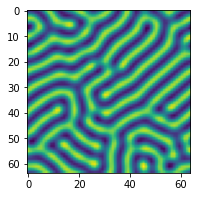

In [1]:
import scipy.io as sio
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('/Users/edwardmcdugald/Research/convection_patterns_wip/code/ml_experiments')
from myPDEFIND import *
sys.path.append('/Users/edwardmcdugald/Research/convection_patterns_wip/code/numerics')
import convection_patterns as cp

cp.solveSH(20*np.pi,20*np.pi,256,256,.1,100,"SHAutoEncode_2",Rscale=.5,
           beta=.45,amplitude=.1,init_flag=1,energy=False)

data = sio.loadmat("/Users/edwardmcdugald/Research/convection_patterns_wip/code/data/SHAutoEncode_2.mat")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
ax.imshow(data['uu'][:,:,500].T)

Load data, and make sure it looks ok

In [19]:
tt = data['tt'][0][1:] #TVALUES, EXCLUDING FIRST ONE
xx = data['xx']
yy = data['yy']
U = data['uu'][:,:,1:] #TAKE LAST 1000 U surfaces
dt = data['tt'][0][1]-data['tt'][0][0]
Ut = BackwardDiff(U,data['uu'][:,:,0:1000],dt) #Compute U derivatives
n_samples = len(tt)
N = len(xx)*len(yy)
perm = np.random.permutation(int(.9*n_samples))
training_samples = perm[:int(.8*n_samples)]
val_samples = perm[int(.8*n_samples):]
test_samples = np.arange(int(.9*n_samples), n_samples)

training_data = {'tt': tt[training_samples],
                     'xx': xx.T,
                     'yy': yy.T,
                     'U': U[:,:,training_samples],
                     'Ut': Ut[:,:,training_samples]}
val_data = {'tt': tt[val_samples],
                'xx': xx.T,
                'yy': yy.T,
                'U': U[:,:,val_samples],
                'Ut': Ut[:,:,val_samples]}
test_data = {'tt': tt[test_samples],
                 'xx': xx.T,
                 'yy': yy.T,
                 'U': U[:,:,test_samples],
                 'Ut': Ut[:,:,test_samples]}


Split data into train and test

In [1]:
from keras.layers import Input, Dense, Conv2D, Conv1D, MaxPooling2D, UpSampling2D
from keras.models import Model
import tensorflow as tf

print(np.shape(training_data['U']))

input_data = tf.keras.layers.Input(shape=(len(xx), len(yy),1))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same')(input_data)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
encoder = tf.keras.models.Model(input_data, encoded)
encoder.summary()

decoder_input= tf.keras.layers.Input(shape=(len(xx), len(yy),1))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same')(decoder_input)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoder = tf.keras.modelsModel(decoder_input, decoded)
decoder.summary()

auto_input = tf.keras.layers.Input(shape=(len(xx),len(yy),1))
encoded = encoder(auto_input)
decoded = decoder(encoded)
auto_encoder = Model(auto_input, decoded)
auto_encoder.summary()

# auto_encoder.compile(loss='mean_squared_error', optimizer='adam')
#
# auto_encoder.fit(training_data['U'].T, training_data['U'].T,
#                 epochs=20,
#                 batch_size=20
#                 #shuffle=True,
#                 #validation_data=(test_data['U'].T, test_data['U'].T)
#                )

NameError: name 'np' is not defined

Auto encoder for data on square grid